# Consumer Behavior Analytics - Data Modelling  of `customers_exposed`

**Libraries and imports**

In [1]:
# Basic DS libraries
import pandas as pd
import numpy as np

# DataViz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics Libraries
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Data Utils
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
                                                                     recall_score, \
                                                                     precision_score, \
                                                                     accuracy_score, \
                                                                     roc_auc_score, \
                                                                     auc, \
                                                                     plot_confusion_matrix, \
                                                                     plot_roc_curve
                                                                         
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from xgboost import XGBClassifier

import pickle
import joblib

# Notebook setup
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Loading customers exposed
customers_exposed = pd.read_csv('../data/customers_exposed_ohe.csv')

In [3]:
customers_exposed.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age,Dt_Customer_InDays,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1,58138.0,1617,0.027813,25,64.68,57,37,0,0,1,0,0,0,0,1,0,0
1,1974,30351.0,1,0,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,1,3,10117.0,46,0.004547,6,7.67,40,312,0,0,0,0,1,0,0,0,1,0
2,1950,5648.0,1,1,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,4,1412.0,49,0.034703,2,24.50,64,592,0,0,0,0,1,0,0,0,1,0
3,1946,82800.0,0,0,23,1006,22,115,59,68,45,1,7,6,12,3,0,0,1,1,0,0,1,1,82800.0,1315,0.015882,26,50.58,68,118,0,0,0,0,1,0,0,1,0,0
4,1949,76995.0,0,1,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,0,1,0,0,0,3,25665.0,1782,0.069433,26,68.54,65,242,0,0,0,1,0,0,1,0,0,0


In [4]:
# Checking class balance (or imballance)
customers_exposed['Response'].value_counts(normalize = True)

1    0.5486
0    0.4514
Name: Response, dtype: float64

## Data Preparation

We are going to start preparing the data for modelling regarding both datasets: `customers_whole` and `customers_exposed`, but only until One Hot Encoding.

After that, we will save both one hot encoded dataframes into new csv files and split both analysis in different notebooks. The analysis in this notebook will be for `customers_whole` dataset.

In [5]:
# # Defining Sample first_date
# first_date = customers_whole['Dt_Customer'].min()

# # Transforming datetime feature to numeric feature
# for df in [customers_exposed, customers_whole]:
#     df['Dt_Customer_InDays'] = df['Dt_Customer'] - first_date
    
#     df['Dt_Customer_InDays'] = (df['Dt_Customer_InDays'] / np.timedelta64(1, 'D')).astype(int) + 1
    
#     # Dropping unuseful columns for modelling
#     df.drop(['ID', 'Dt_Customer'], axis = 1, inplace = True)

In [6]:
# # One Hot Encoding categorical features with pd.get_dummies
# customers_exposed_ohe = pd.get_dummies(customers_exposed)
# customers_whole_ohe = pd.get_dummies(customers_whole)

In [7]:
# # Saving One Hot Enconded files into a new csv file
# customers_whole_ohe.to_csv('../data/customers_whole_ohe.csv', header = True, index = False)
# # pd.read_csv('../data/customers_whole_ohe.csv')

# customers_exposed_ohe.to_csv('../data/customers_exposed_ohe.csv', header = True, index = False)
# # pd.read_csv('../data/customers_exposed_ohe.csv')

Both files have been saved! We will not need to load the `customers_whole_ohe.csv` into this notebook, but it is aways good to keep a standartd log of actions.

**We will move forward with modelling for the `customers_whole` dataset hereafter.**

Let's start:

### Splitting Data into _Train_, _Validation_ and _Test_ sets

We will split the data according to the following schedule:

- Create a `df_train` and a `df_test`.
- From the previous `df_train` we will once again split it into two: `df_train` and `df_val`.

We also know that _specially_ in this dataset (`_whole`) we have unballanced data. So we will perform a oversampling technique called SMOTE. According to the paper published in _The Journal of Artificial Intelligence Research_ in 2002:

> [With SMOTE] The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the $k$ minority class nearest neighbors. Depending upon the amount of over-sampling required, neighbors from the k nearest neighbors are randomly chosen.[$^{SMOTE: \: Synthetic\:Minority\:Over-sampling\:Technique}$](https://arxiv.org/pdf/1106.1813.pdf)

- Finally, we will separate all dfs into `X`'s and `y`, naming respectively accordint to the df they belong to.

Let's start:

In [8]:
# Splitting df_train and df_test for training and testing
df_train, df_test = train_test_split(customers_exposed, test_size = .2, random_state = 7)

In [9]:
# Savint test set to a new csv file
df_test.to_csv('../data/tests_sets/df_test_pure-customers_exposed.csv', header = True, index = False)

In [10]:
# Splitting df_train into df_train and df_val
df_train, df_val = train_test_split(df_train, test_size = .2, random_state = 7)

In [11]:
# Checking target variable balance (or imballance)
df_train['Response'].value_counts()

1    212
0    176
Name: Response, dtype: int64

In [12]:
# Balancing target variable with SMOTE technique

# Instantiating SMOTER over_sampler
smote = SMOTE(random_state = 7)

# Fitting and resampling data with SMOTE
X_train, y_train = smote.fit_resample(df_train.drop('Response', axis = 1), df_train['Response'])

# Checking target class balance
y_train.value_counts()

0    212
1    212
Name: Response, dtype: int64

In [13]:
X_val = df_val.drop('Response', axis = 1)
y_val = df_val['Response']

X_test = df_test.drop('Response', axis = 1)
y_test = df_test['Response']

Let's check if the generated `X`'s and `y`'s are correctly built:

In [14]:
print('X_train, y_train   shapes: ', X_train.shape, y_train.shape)
print('X_val  , y_val     shapes: ', X_val.shape, y_val.shape)
print('X_test , y_test    shapes: ', X_test.shape, y_test.shape)

X_train, y_train   shapes:  (424, 40) (424,)
X_val  , y_val     shapes:  (97, 40) (97,)
X_test , y_test    shapes:  (122, 40) (122,)


**All shapes match**. We are good to go on.

In [15]:
# rf_model2 = RandomForestClassifier()
# param_grid = {
#             'n_estimators': [50, 60, 70, 80, 90, 100],
#             'max_depth': np.arange(0, 10),
#             'min_samples_split': np.arange(0, 10),
#             'min_samples_leaf': stats.loguniform(.01, 1),
#         }
# rf_model_rsearch = RandomizedSearchCV(rf_model2, param_distributions = param_grid, cv = 10, 
#                                       n_jobs = -1, scoring = 'f1', random_state = 7, n_iter = 50, verbose = 1)

In [16]:
# rf_model_rsearch.fit(X_train, y_train)

In [17]:
# print(classification_report(y_val, rf_model_rsearch.predict(X_val)))

### Analyzing multicolinearity

In the previous notebooks, we have created new variables from pre-existing variables. Therefore we made room for possible multicolinearity.

Some techniques for analyzing multicolinearity are:

- Checking correlation values between variables;
- Checking the Variance Inflation Factor (VIF) and dropping variables with factor $> 10$;
- Performing Principal Component Analysis, to the cost of lesser interpretability;
- Perform regularization such as (Lasso or Ridge) for linear models, such as Logistic Regression;

For the sake of simplicity, let's go foward with `VIF` and drop variables with factor $ >10$:

In [18]:
X_train.columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Family_Size', 'Income_PerCap',
       'Total_Spent', 'Prop_Spending_Income_pc', 'Total_Puchases',
       'Avg_Ticket', 'Age', 'Dt_Customer_InDays', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow'],
      dtype='object')

In [19]:
# Separating numeric features in a list, except booleans
numeric_features = [
    'Year_Birth', 
#     'Education',
    'Income', 
    'Kidhome',                
    'Teenhome', 
    'Recency', 
    'MntWines', 
    'MntFruits',
    'MntMeatProducts', 
    'MntFishProducts', 
    'MntSweetProducts',
    'MntGoldProds', 
    'NumDealsPurchases', 
    'NumWebPurchases',
    'NumCatalogPurchases', 
    'NumStorePurchases', 
    'NumWebVisitsMonth',
    'Total_Spent',
    'Total_Puchases',
    'Family_Size',
    'Income_PerCap',
    'Prop_Spending_Income_pc', 
    'Avg_Ticket', 
    'Age', 
    'Dt_Customer_InDays'
]

In [20]:
# Creating a list of varibles for VIF analysis

################################################################################################
#   This cell has been iterated "mannually" after checking vif values in the dataframe below   #
################################################################################################

numeric_features_vif_ok = [
#     'Year_Birth', 
#     'Education',
#     'Income', 
    'Kidhome',                
    'Teenhome', 
    'Recency', 
#     'MntWines', 
#     'MntFruits',
#     'MntMeatProducts', 
#     'MntFishProducts', 
#     'MntSweetProducts',
    'MntGoldProds', 
#     'NumDealsPurchases', 
#     'NumWebPurchases',
#     'NumCatalogPurchases', 
#     'NumStorePurchases', 
#     'NumWebVisitsMonth',
#     'Total_Spent',
#     'Total_Puchases',
#     'Family_Size',
    'Income_PerCap',
    'Prop_Spending_Income_pc', 
    'Avg_Ticket', 
#     'Age', 
    'Dt_Customer_InDays'
]

In [21]:
# Creating a dataframe for storing vif and its respective variable
vif_df = pd.DataFrame()

# Calculating vif values and saving it into vif_index columns
vif_df["vif_index"] = [vif(X_train[numeric_features_vif_ok].values, i) \
                               for i in range(X_train[numeric_features_vif_ok].shape[1])]

# Saving variable name into feature column
vif_df["feature"] = X_train[numeric_features_vif_ok].columns

# Checking results
vif_df

,vif_index,feature
0,1.475610,Kidhome
1,2.043968,Teenhome
2,3.314574,Recency
3,2.413804,MntGoldProds
4,3.562519,Income_PerCap
5,4.257530,Prop_Spending_Income_pc
6,1.602235,Avg_Ticket
7,3.111658,Dt_Customer_InDays


All `VIF` factor are now $\le 10$, we can start dealing with the different orders of magnitude in our numeric features. 

In [22]:
to_drop_from_vif = [feature for feature in numeric_features if feature not in numeric_features_vif_ok]

In [23]:
# to_drop_from_vif

### Scaling

In order to have the numeric data in the same order of magnite, we will:

- Use RobustScaler for variables with outliers;
- Use StandardScaler for variables with no outliers;


Let's start by listing features with outliers:

**Getting features with ouliers**

In [24]:
# Listing features names if feature has outlier
to_robust_scale = []
for feature in numeric_features:
    
    Q1 = np.percentile(X_train[feature].sort_values(), 25, interpolation = 'midpoint')  
    Q3 = np.percentile(X_train[feature].sort_values(), 75, interpolation = 'midpoint')  

    IQR = Q3 - Q1  
    
    low_lim = Q1 - 1.5 * IQR 
    up_lim = Q3 + 1.5 * IQR 

    if (X_train[feature] > up_lim).any() or (X_train[feature] < low_lim).any(): 
         to_robust_scale.append(feature)

to_robust_scale

['MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebVisitsMonth',
 'Family_Size',
 'Income_PerCap',
 'Prop_Spending_Income_pc',
 'Avg_Ticket']

And then, from the previous list, we can list the variables that will be standardized:

**Listing features _without_ outliers**

In [25]:
to_standardize = [feature for feature in numeric_features if feature not in to_robust_scale]
to_standardize

['Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'Total_Spent',
 'Total_Puchases',
 'Age',
 'Dt_Customer_InDays']

**Applying RobustScaler to variables listed in `to_robust_scale` list**

In [26]:
robust_scaler = RobustScaler()
robust_scaler.fit(X_train[to_robust_scale])

X_train_scaled = X_train.copy()
X_train_scaled[to_robust_scale] = robust_scaler.transform(X_train[to_robust_scale])

**Applying StandardScaler to variables listed in `to_standardize` list**

In [27]:
stand_scaler = StandardScaler()

stand_scaler.fit(X_train[to_standardize])
X_train_scaled[to_standardize] = stand_scaler.transform(X_train[to_standardize])

Let's check the `X_train` dataset to see if everything went well:

In [28]:
# Checking statistics from scaled DFs
round(X_train_scaled.describe(), 2)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Family_Size,Income_PerCap,Total_Spent,Prop_Spending_Income_pc,Total_Puchases,Avg_Ticket,Age,Dt_Customer_InDays,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
count,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.0,424.00,424.00,424.00,424.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.34,0.41,0.43,0.38,0.59,0.00,-0.00,0.00,-0.21,0.28,0.27,0.25,0.22,0.04,0.00,0.35,0.23,-0.00,0.10,0.00,0.23,-0.00,-0.00,0.07,0.01,0.48,0.15,0.24,0.1,0.33,0.23,0.24,0.04
std,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.69,0.91,0.98,0.98,0.95,1.00,1.00,1.00,0.66,0.45,0.44,0.43,0.41,0.20,0.05,0.94,0.86,1.00,0.69,1.00,1.78,1.00,1.00,0.25,0.10,0.50,0.35,0.43,0.3,0.47,0.42,0.43,0.20
min,-2.25,-2.58,-0.66,-0.74,-1.57,-1.27,-0.39,-0.30,-0.29,-0.32,-0.61,-0.50,-1.92,-1.36,-1.95,-1.50,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-0.94,-1.37,-0.93,-2.40,-0.78,-2.33,-1.59,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
25%,-0.83,-0.85,-0.66,-0.74,-0.84,-0.93,-0.32,-0.22,-0.25,-0.28,-0.28,0.00,-0.75,-1.02,-0.74,-0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.46,-0.99,-0.43,-0.67,-0.46,-0.69,-0.88,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
50%,0.09,0.12,-0.66,-0.74,-0.10,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,-0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,-0.00,-0.08,-0.10,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
75%,0.67,0.80,1.40,1.09,0.82,0.78,0.68,0.78,0.75,0.72,0.72,1.00,0.79,0.71,0.78,0.25,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.54,0.82,0.57,0.64,0.54,0.84,0.84,0.00,0.00,1.00,0.00,0.00,0.0,1.00,0.00,0.00,0.00
max,2.34,2.09,3.45,2.93,1.86,2.39,4.00,3.63,3.41,3.87,3.61,5.00,2.34,2.43,1.99,3.50,1.00,1.00,1.00,1.00,1.00,1.00,3.00,2.76,2.29,2.83,2.37,32.99,2.26,1.79,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00


The dataset seems alright.

Aiming to avoid **data leakage**, we've performed the `.fit` method using only the `X_train` dataset. We need now to `.transform` the values from `X_val` and `X_test` datasets so we can use them later to make predictions and evaluate our model.

In [29]:
# Transforming x_val and x_test with scalers from X_train
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_val_scaled[to_robust_scale] = robust_scaler.transform(X_val[to_robust_scale])
X_test_scaled[to_robust_scale] = robust_scaler.transform(X_test[to_robust_scale])

X_val_scaled[to_standardize] = stand_scaler.transform(X_val[to_standardize])
X_test_scaled[to_standardize] = stand_scaler.transform(X_test[to_standardize])

In [30]:
# Checking transformed datasets
# X_val.head() # Uncomment to view dataframes
# X_test.head()

In [31]:
X_train.to_csv('../data/tests_sets/X_train-customers_exposed.csv', header = True, index = False)
y_train.to_csv('../data/tests_sets/y_train-customers_exposed.csv', header = True, index = False)

X_val.to_csv('../data/tests_sets/X_val-customers_exposed.csv', header = True, index = False)
y_val.to_csv('../data/tests_sets/y_val-customers_exposed.csv', header = True, index = False)

X_test.to_csv('../data/tests_sets/X_test-customers_exposed.csv', header = True, index = False)
y_test.to_csv('../data/tests_sets/y_test-customers_exposed.csv', header = True, index = False)

## Baseline Model

Let's start with a baseline model.

A baseline model is a good pratice to determine if all sweat put into modelling with different algorithms and hyperparameter tuning is worth the effort.

We can use a simple **Linear Regression**, not tunned, model as our baseline.

### Simple LinearRegression

In [32]:
# Instantiating the model
log_model = LogisticRegression()

# Fitting the model
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [33]:
# predicting using X_val
y_val_pred = log_model.predict(X_val_scaled)
# y_val_pred

In [34]:
# Evaluating metrics with Skelearn Classification Report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.67      0.74      0.71        39
           1       0.81      0.76      0.79        58

    accuracy                           0.75        97
   macro avg       0.74      0.75      0.75        97
weighted avg       0.76      0.75      0.75        97



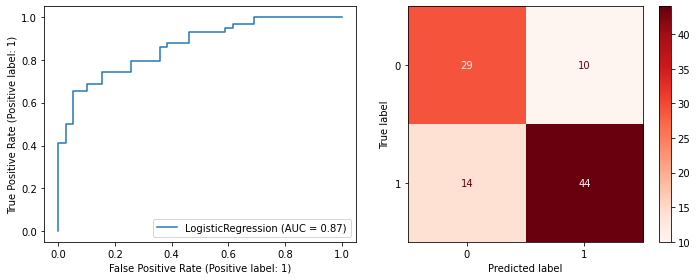

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
plot_roc_curve(log_model, X_val_scaled, y_val, ax = ax[0])
plot_confusion_matrix(log_model, X_val_scaled, y_val, cmap=plt.cm.Reds, ax = ax[1])
plt.tight_layout()

### Keeping metrics logs in MLFlow

In [36]:
from mlflow.tracking import MlflowClient

EXPERIMENT_NAME = '[v3.9] [customers_exposed] [Consumer Behavior Analytics] [Renan Moises]'

client = MlflowClient()
experiment_id = client.create_experiment(EXPERIMENT_NAME)

In [37]:
metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
metrics = [accuracy_score, precision_score, recall_score, f1_score]

In [38]:
run = client.create_run(experiment_id)

client.log_param(run.info.run_id, 'model', 'LogistRegression-Baseline')

for metric in zip(metrics_names, metrics):
    client.log_metric(run.info.run_id, metric[0], metric[1](y_val, y_val_pred))

## Modelling for Real

- LogisticRegression (tunned)
- KNNClassifier
- SVC
- RFClassifier
- AdaBoost
- GradientBoostClassifier
- XGBoostClassifier

In [39]:
models = {
    'LogisticRegression-Tunned': LogisticRegression(),
    'KNNClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGboostClassifier': XGBClassifier()
}

In [ ]:
for model_key, model_value in models.items():
#     X_train_modelling = X_train.copy().drop(to_drop_from_vif, axis = 1)
#     X_val_modelling = X_val.copy().drop(to_drop_from_vif, axis = 1)
    
    X_train_modelling = X_train.copy()
    X_val_modelling = X_val.copy()

    
    if model_key == 'LogisticRegression-Tunned':
        # Dropping Multicolinear Features for Logistic Regression
        X_train_modelling = X_train_scaled.drop(to_drop_from_vif, axis = 1)
        X_val_modelling = X_val_scaled.drop(to_drop_from_vif, axis = 1)
        
        param_grid = {
            'penalty': ['l2', 'l1', 'elasticnet'],
            'tol': stats.loguniform(0.1, 1),
            'C': stats.loguniform(3, 10)
        }
    
    elif model_key == 'KNNClassifier':
        # Dropping Multicolinear Features for KNNClassifier
        X_train_modelling = X_train_scaled.drop(to_drop_from_vif, axis = 1)
        X_val_modelling = X_val_scaled.drop(to_drop_from_vif, axis = 1)
        
        param_grid = {'n_neighbors':[3, 4, 5, 6, 7]}
    
    elif model_key == 'SVC':
        # Dropping Multicolinear Features for SVC
        X_train_modelling = X_train_scaled.drop(to_drop_from_vif, axis = 1)
        X_val_modelling = X_val_scaled.drop(to_drop_from_vif, axis = 1)
        
        param_grid = {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': stats.loguniform(3, 20)
        }
    
    elif model_key == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': np.arange(0, 10),
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
        }
    
    elif model_key == 'AdaBoostClassifier':
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'learning_rate': stats.lognorm(.001, 1)
        }
    
    elif model_key == 'GradientBoostingClassifier':
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'learning_rate': stats.loguniform(.001, 1),
            'min_samples_split': np.arange(0, 10),
            'min_samples_leaf': stats.loguniform(.01, 1),
            'max_depth': np.arange(0, 10)
        }
    
    else:
        param_grid = {
            'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
            'learning_rate': stats.loguniform(.001, 1),            
            'max_depth': np.arange(0, 10),
            'gamma': stats.loguniform(.001, 1),
        }   
    
    
    # Running RandomizedSearchCV
    print(model_key, '#'.replace('#', '#'*(61 - len(model_key))))
    model_rsearch = RandomizedSearchCV(model_value, 
                                       param_distributions = param_grid, 
                                       n_iter = 50, 
                                       scoring = 'f1', # Used to update weights
                                       cv = 10, 
                                       n_jobs = -1, 
                                       verbose = 1,
                                       random_state = 7)
    
    # Fitting the model to the train data
    model_rsearch.fit(X_train_modelling, y_train)
    
    # Saving model as a joblib file
#     joblib.dump(model_rsearch, f'../models/cexposed_{model_key}.pkl')
    with open(f"../models/pkl_cexposed_{model_key}.pkl", "wb") as file:
        pickle.dump(model_rsearch, file)

    
    # Predictions using X_val
    y_val_pred = model_rsearch.predict(X_val_modelling)
    
    # Setting up metrics
    metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    
    # MLFlow Logs
    run = client.create_run(experiment_id)
    for metric_name, metric in zip(metrics_names, metrics):
        client.log_metric(run.info.run_id, metric_name, metric(y_val, y_val_pred))
    client.log_param(run.info.run_id, "model", model_key)
    client.log_param(run.info.run_id, "params", model_value.get_params())
    client.log_param(run.info.run_id, "features", X_train_modelling.columns.tolist())

    
    print(classification_report(y_val, y_val_pred), '\n')

LogisticRegression-Tunned ####################################
Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [ ]:
# grad_boost_param_grid = {
#             'n_estimators': np.array([50, 60, 70, 80, 90, 100, 120, 150, 200, 400], dtype = int),
#             'learning_rate': stats.lognorm(.001, 1),
#             'min_samples_split': np.arange(0, 10),
#             'min_samples_leaf': stats.loguniform(.01, 1),
#             'max_depth': np.arange(0, 10)
#         }

In [ ]:
# gradboost_model = GradientBoostingClassifier()

# gradboost_model_rsearch = RandomizedSearchCV(gradboost_model, param_distributions = grad_boost_param_grid,
#                                              n_iter = 50, 
#                                              scoring = 'f1', # Used to update weights
#                                              cv = 10, 
#                                              n_jobs = -1, 
#                                              verbose = 1,
#                                              random_state = 7)

In [ ]:
# gradboost_model_rsearch.fit(X_train, y_train)

In [ ]:
# print(classification_report(y_val, gradboost_model_rsearch.predict(X_val)))

In [ ]:
# print(classification_report(y_test, gradboost_model_rsearch.predict(X_test)))

In [ ]:
# cv

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize = (10, 4))
# plot_roc_curve(gradboost_model_rsearch, X_val, y_val, ax = ax[0])
# plot_confusion_matrix(gradboost_model_rsearch, X_val, y_val, cmap=plt.cm.Reds, ax = ax[1])
# plt.tight_layout()

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize = (10, 4))
# plot_roc_curve(log_model, X_test_scaled, y_test, ax = ax[0])
# plot_confusion_matrix(log_model, X_test_scaled, y_test, cmap=plt.cm.Reds, ax = ax[1])
# plt.tight_layout()

___________________

In [ ]:
############# DRAFTS

In [ ]:
# X_train_scaled.rename(columns={'Education_2n Cycle': 'Education_2n_Cycle'}, inplace = True)
# X_val_scaled.rename(columns={'Education_2n Cycle': 'Education_2n_Cycle'}, inplace = True)
# X_test_scaled.rename(columns={'Education_2n Cycle': 'Education_2n_Cycle'}, inplace = True)